In [111]:
#!/usr/bin/env python

#comment out if not using jupyter
%matplotlib inline 

#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

from scipy.integrate import odeint
from scipy.optimize import curve_fit

#from scipy.stats import pearsonr,spearmanr
#from scipy.interpolate import interp1d


In [112]:
gene=['Gag','Env'][1]

#import data
df=pd.read_csv('data/053119_Proportions_'+gene+'.csv')
dfseed=pd.read_csv('data/HIV_DNA_Seeding_Timepoint_'+gene+'.csv')

In [113]:
#ids and colors
IDs=['QG262', 'QC885', 'QF564', 'QB726', 'QD022', 'QB045'] #put them in order of rest of paper
czpat=['#CD5C5C','#014421','#FF8C00','#4682B4','#A57C00','#B284BE']


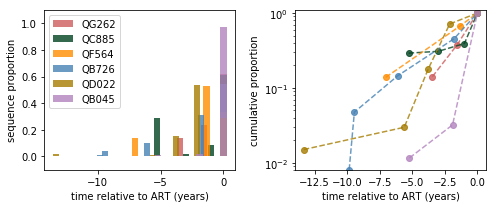

In [114]:
#raw data all together
plt.figure(figsize=(7,3))

ind=0
for i in IDs:
    
    tdfP=dfseed[dfseed['ID']==i]    
    dat_t=-np.array(tdfP['Years_Prior_to_ART'])
    dat_prop=np.array(tdfP['Proportion_Each'])
    
    cdf_t=np.flipud(dat_t)
    cdf_prop=np.cumsum(np.flipud(dat_prop))
    
    plt.subplot(121)
    plt.bar(dat_t,dat_prop,width=0.5,facecolor=czpat[ind],alpha=0.8,label=i)
    #plt.plot(dat_t,dat_prop,'o',color=czpat[ind],alpha=0.8)
    #for ii in range(len(dat_t)):
    #    plt.plot([-dat_t[ii],-dat_t[ii]],[0,dat_prop[ii]],'-',color=czpat[ind],lw=4,alpha=0.5)
    plt.ylabel('sequence proportion')
    plt.xlabel('time relative to ART (years)')
    plt.ylim([-0.1,1.1])
    plt.legend()
    
    plt.subplot(122)
    plt.semilogy(cdf_t,cdf_prop,ls='--',marker='o',color=czpat[ind],alpha=0.8)
    plt.xlabel('time relative to ART (years)')
    plt.ylabel('cumulative proportion')
    plt.ylim([-0.1,1.1])

    
    ind+=1
plt.tight_layout()
plt.savefig('figures/'+gene+'_alldata.pdf',dpi=600)

In [115]:
## functions to do the whole fitting process ##

#use nested functions to pass in initial viral load 
#becaues this determines other initial conditions
def make_solver(V0,flg):

    #fixed parameters for fitting
    aS  = 70;    #constant growth rate of susceptibles [cells/uL/day]
    Bt0 = 1e-4   #infection rate of T-cells [uL/cells-day]/[uL]
    dI  = 0.8    #active death rate [1/day]
    p   = 5e4    # burst rate of virus from cells [virions/cell]
    g   = 23     #virus clearance rate [1/day]
    thL = 5.2e-4 #latent clearance rate [1/day]
    aE  = 1e-4;  #initial E cell concentration [cells/uL]*[uL]
    V0=0.03    
    
    #complete HIV primary infection model for fitting
    def model(X,t,aS,dS,Bt0,tau,lam,dI,k,aE,dE,E50,w,p,g):
        dY = np.zeros(7);
        S=X[0]; AU=X[1]; AP=X[2]; LU=X[3]; LP=X[4]; E=X[5]; V=X[6];    
        dY[0] = aS - dS*S - Bt0*S*V                                  #susceptible cells
        dY[1] = (1-tau)*(1-lam)*Bt0*S*V - dI*AU - k*E*AU   #active unproductively infected
        dY[2] = tau*(1-lam)*Bt0*S*V - dI*AP - k*E*AP       #active productively infected
        dY[3] = (1-tau)*lam*Bt0*S*V       #latent unproductively infected
        dY[4] = tau*lam*Bt0*S*V            #latent productively infected
        dY[5] = aE + w*E*(AP+AU)/(E+E50) - dE*E;                     #adaptive immune system
        dY[6] = p*AP - g*V - Bt0*S*V                                 #virus
        return dY
    
    #the model that has the right number of estimated params and will be fit
    def solve_model(tt,dS,tau,k,dE,E50,w,lam):  
        #set up initial conditions
        S0=aS/dS; E0=aE/dE #compute equilibria for these    
        I0=g/p*V0 #quasistatic approximation for VL and infected cells
        #calculate the rest of initial conditions from more quasistatic approx
        X0=np.array([S0,
                     I0*(1-tau)*(1-lam), #unproductive active
                     I0*tau*(1-lam),     #productive active
                     I0*(1-tau)*lam,     #unproductive latent
                     I0*tau*lam,         #productive latent
                     E0,
                     V0])

        #solve model using initialize for initial conditions
        sol=odeint(model, X0, tt, (aS,dS,Bt0,tau,lam,dI,k,aE,dE,E50,w,p,g), mxstep=10000) 
        VL=np.log10(sol[:,6]*1e3) #viral load as usual units copies/mL
        
        if flg=='fit':
            return VL
        if flg=='sim':
            params=aS,dS,Bt0,tau,lam,dI,aE,p,g
            return sol,params
        else:
            print('specify your model to be fit or simulated')
    
    return solve_model

#function to make arrays for boundaries during fitting process
def make_bounds(guess,fac):
    bounds=tuple([tuple(np.array(guess)/fac),tuple(np.array(guess)*fac)])
    return bounds

In [116]:
#additional functions

#make a step thing for plotting
def make_step(L):
    ystep=[]
    xstep=[]
    for i in range(len(L)):
        ystep.append(L[i])
        ystep.append(L[i])
        xstep.append(i)
        xstep.append(i+1) 
    return np.array(xstep),np.array(ystep)

#calculate the interval creation, could do biphasic, but not yet
#tpre is time before ART (years)
#tpost is time after ART (years)
def get_dist(tpre,tpost,hl):

    thL=np.log(2)/(hl/12*365) #convert half life to exponential decay rate per day
    t_sim=np.linspace(0,tpre*365,tpre*100); #put in intervals of 100 and units of days
    s,params=make_solver(V0,'sim')(t_sim,dS,tau,k,dE,E50,w,lam) #simulate model

    L=np.zeros(tpre)
    t=np.arange(tpre)
    for i in range(tpre):
        in1=i*100
        in2=(i+1)*100-1

        L[i]=s[in2,4]-s[in1,4] #just do LU

    Lcre=L/np.sum(L) #proportions created
    
    #now subtract off decay
    Ltot=L*np.exp(-thL*365*(np.flipud(t)+tpost))
    Ltot=Ltot/np.sum(Ltot) #total proportions created

    t,Lcrestep=make_step(Lcre)
    t,Ltotstep=make_step(Ltot)

    return np.array(t), np.array(Lcrestep), np.array(Ltotstep)



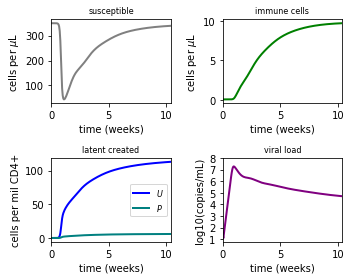

In [117]:
#list of parameters
dS  = 0.2;   #susceptible death rate [1/day] 
tau = 0.05   #productive infection probability []
k   = 0.3;   #immune cell killing rate [uL/cell-day]/[uL]
w   = 1.6;   #immune cell multiplier [1/day]
dE  = 0.002; #immune death rate [1/day]
E50 = 250;   #50 pct max E cell concentration [cells/uL]*[uL]
lam = 1e-4

#plot all cell states
maxyr=10
V0=0.03

t_sim=np.linspace(0,maxyr*365,maxyr*1000);

s,params=make_solver(V0,'sim')(t_sim,dS,tau,k,dE,E50,w,lam)

sol=s[:200,:]
t=t_sim[:200]/7

plt.figure(figsize=(5,4))

plt.subplot(221)
plt.plot(t,sol[:,0],'gray',lw=2)
plt.ylabel('cells per $\mu$L')
plt.title('susceptible',fontsize=8)

plt.subplot(222)
plt.plot(t,sol[:,5],'green',lw=2) #immune cells
#plt.plot(t,sol[:,5]*k/(dI*2+sol[:,5]*k)*100,'green',lw=2) #fraction from immunity (It cancels out)
plt.ylabel('cells per $\mu$L')
#plt.ylabel('pct of infected \n cell death from \n adaptive immunity')
#plt.ylim([0,100])
plt.title('immune cells',fontsize=8)

plt.subplot(223)
plt.plot(t,sol[:,3]*1000,'blue',lw=2) #divide by 1000 CD4+ T cells and then multiply by 1 million
plt.plot(t,sol[:,4]*1000,'teal',lw=2)
plt.ylabel('cells per mil CD4+')
plt.legend(['$U$','$P$'],fontsize=8)
plt.title('latent created',fontsize=8)

plt.subplot(224)
plt.plot(t,np.log10(sol[:,6]*1e3),'purple',lw=2)
plt.ylabel('log10(copies/mL)')
plt.yticks(range(1,9,1))
plt.title('viral load',fontsize=8)

for i in range(4):
    plt.subplot(221+i)
    plt.xlabel('time (weeks)')
    #plt.xticks(np.arange(0,maxyr,0.5))
    plt.xlim([0,max(t)])
#fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
plt.tight_layout()
plt.savefig('figures/model_statevars.pdf')


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


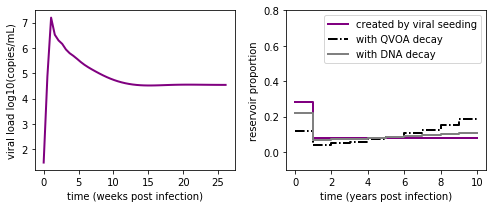

In [118]:
#example plot to illustrate modeling
plt.figure(figsize=(7,3))

maxyr=0.5
t_sim=np.linspace(0,maxyr*365,maxyr*100);
sol,params=make_solver(V0,'sim')(t_sim,dS,tau,k,dE,E50,w,lam)

plt.subplot(121)
plt.plot(t_sim/7,np.log10(sol[:,6]*1e3),'purple',lw=2)
plt.ylabel('viral load log10(copies/mL)')
plt.xlabel('time (weeks post infection)')

plt.subplot(122)

#use Siliciano
hl=44
t,Lcre,Ltot=get_dist(10,2,hl)
plt.plot(t,Lcre,label='created by viral seeding',color='purple',lw=2)
plt.plot(t,Ltot,label='with QVOA decay',color='k',ls='-.',lw=2)

#use Golob
hl=139
t,Lcre,Ltot=get_dist(10,2,hl)
plt.plot(t,Ltot,label='with DNA decay',color='gray',lw=2)

plt.ylim([-0.1,0.8])
#plt.xticks(t)
plt.legend()
plt.xlabel('time (years post infection)')
plt.ylabel('reservoir proportion')

plt.tight_layout()
plt.savefig('figures/model_example.pdf',dpi=600)

QG262 0.40074491607531004 0.00032560538410930645
QC885 0.40551037677599155 0.0002686950986053785
QF564 0.1387640568488303 0.38183252846747917
QB726 0.3604712641075987 0.0015079915507447055
QD022 0.3718543733480135 0.0009939896648448062
QB045 0.5965600877850208 1.871020169033736e-08


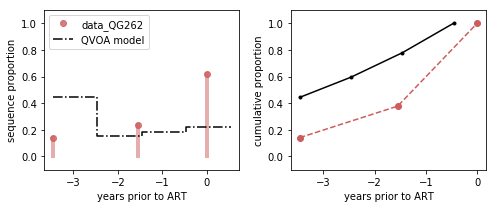

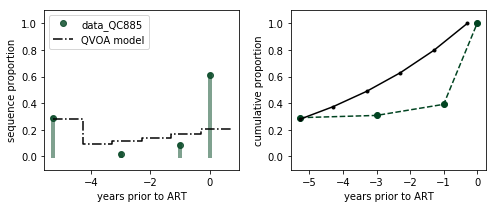

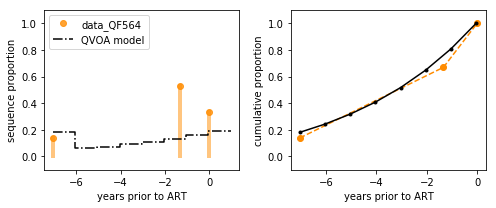

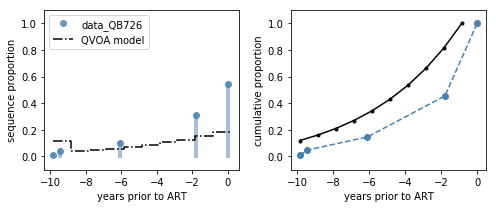

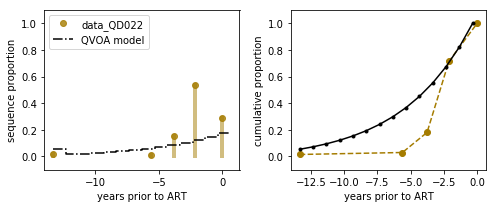

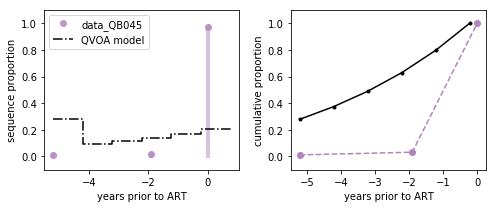

In [119]:
#ode modeling of reservoir seeding, plot all separately with cdf too

ind=0
for i in IDs:
    
    #get data
    tdfP=dfseed[dfseed['ID']==i]    
    dat_t=-np.flipud(tdfP['Years_Prior_to_ART'])
    dat_prop=np.flipud(tdfP['Proportion_Each'])
    dat_cdf = np.cumsum(dat_prop)
    
    #simulate data
    tpretrue=-dat_t[0]
    tprerounded=int(np.ceil(tpretrue))
    sim_t,Lcre,sim_prop=get_dist(tprerounded,tpost=2,hl=44)
    plotsim_t=sim_t-max(sim_t)-tpretrue+tprerounded #readjust after rounding for plots
    
    model_t=plotsim_t[::2]
    model_cdf=np.cumsum(sim_prop[::2])   
    
    #find the best model time point for each data time point
    D=0
    for it in range(len(dat_t)):
        closest=np.argmin(np.abs(model_t-dat_t[it]))
        d=np.max(np.abs(model_cdf[closest]-dat_cdf[it]))
        if d>D:
            D=d

    #calculate KS differences
    m=50 #experimental sample size
    n=m #model sample size
    alpha=0.01 #p value we are testing
    ks=np.sqrt(-1/2*np.log(alpha))*np.sqrt((n+m)/(n*m))
    pp=np.exp(-2*(D/np.sqrt((n+m)/(n*m)))**2)

    print(i,D,pp)

    #if D>ks:
    #    print(i,'significant, p<'+str(alpha))

    #recalibrate, add zeros
    #model_t=np.append(model_t,0)
    #model_cdf=np.append(model_cdf,1)
    #model_cdf=np.flipud(np.append(np.flipud(model_cdf),0))

    #plot comparisons
    plt.figure(figsize=(7,3))
    plt.subplot(121)
    plt.plot(dat_t,dat_prop,'o',color=czpat[ind],alpha=0.8,label='data_'+i) #plot the data
    for ii in range(len(dat_t)):
        plt.plot([dat_t[ii],dat_t[ii]],[0,dat_prop[ii]],'-',color=czpat[ind],lw=4,alpha=0.5) #make my own bars
    plt.step(plotsim_t,sim_prop,linestyle='-.',color='k',where='post',label='QVOA model') #plot the model
    plt.ylabel('sequence proportion')
    plt.xlabel('years prior to ART')
    plt.ylim([-0.1,1.1])
    plt.legend(loc=2)
    plt.subplot(122)     
    plt.plot(dat_t,dat_cdf,marker='o',ls='--',color=czpat[ind],label='data') #data cdf
    plt.plot(model_t,model_cdf,ls='-',marker='.',color='k',label='QVOA model') #model cdf
    plt.ylabel('cumulative proportion')
    plt.xlabel('years prior to ART')
    plt.ylim([-0.1,1.1])

    plt.tight_layout()
    plt.savefig('figures/modelcomps/'+gene+'_'+i+'.pdf',dpi=600)
    ind+=1


-5.22 0 -5.219999999999999 0.2671569089223657
-1.91 3 -2.219999999999999 0.5965600877850208
-0.0 5 -0.21999999999999975 0.0
final D= 0.5965600877850208


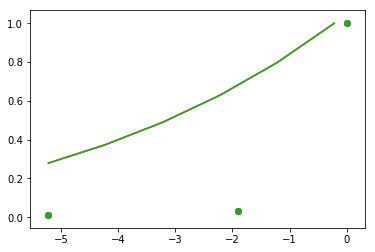

In [120]:
#a helpful example!
#find the best model time point for each data time point

D=0
for it in range(len(dat_t)):
    closest=np.argmin(np.abs(model_t-dat_t[it]))
    d=np.max(np.abs(model_cdf[closest]-dat_cdf[it]))

    print(dat_t[it],closest,model_t[closest],d)

    plt.plot(model_t,model_cdf)
    plt.scatter(dat_t,dat_cdf)
    
    if d>D:
        D=d
        
print('final D=',D)

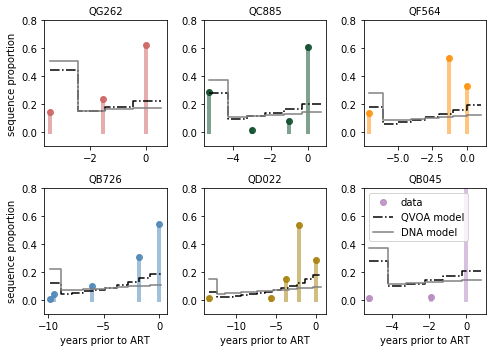

In [121]:
#ode modeling of reservoir seeding, all proportions!
plt.figure(figsize=(7,5))

ind=0 #index for subplots
for iid in IDs:
    
    #get data
    tdfP=dfseed[dfseed['ID']==iid]    
    dat_t=-np.flipud(tdfP['Years_Prior_to_ART'])
    dat_prop=np.flipud(tdfP['Proportion_Each'])
    
    #simulate data
    tpretrue=-dat_t[0]
    tprerounded=int(np.ceil(tpretrue))
    
    #plot data
    ax=plt.subplot(2,3,ind+1)
    ax.plot(dat_t,dat_prop,'o',color=czpat[ind],alpha=0.8,label='data')
    #plt.semilogy()
    for ii in range(len(dat_t)):
        ax.plot([dat_t[ii],dat_t[ii]],[0,dat_prop[ii]],'-',color=czpat[ind],lw=4,alpha=0.5)
    
    #simulate data with siliciano
    sim_t,Lcre,sim_prop=get_dist(tprerounded,tpost=2,hl=44)
    plotsim_t=sim_t-max(sim_t)-tpretrue+tprerounded #readjust after rounding for plots
    ax.plot(plotsim_t,sim_prop,linestyle='-.',color='k',label='QVOA model') #plot the model

    #simulate data with golob
    sim_t,Lcre,sim_prop=get_dist(tprerounded,tpost=2,hl=139)
    plotsim_t=sim_t-max(sim_t)-tpretrue+tprerounded #readjust after rounding for plots
    ax.plot(plotsim_t,sim_prop,linestyle='-',color='gray',label='DNA model') #plot the model
    
    plt.title(iid,fontsize=10)
    if ind%3==0:
        ax.set_ylabel('sequence proportion')
    if ind>2:
        ax.set_xlabel('years prior to ART')
    ax.set_ylim([-0.1,0.8])
    if ind==5:
        ax.legend(loc=2)#bbox_to_anchor=(1.1,1))
    ind+=1
plt.tight_layout()
plt.savefig('figures/'+gene+'_modelprop.pdf',dpi=600)


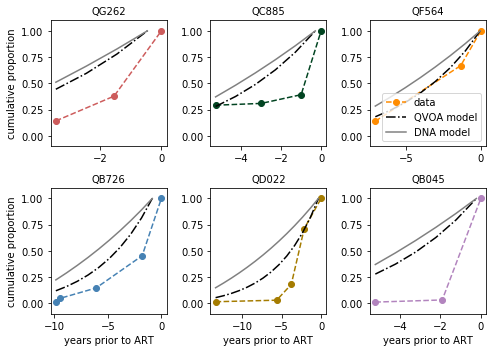

In [122]:
#ode modeling of reservoir seeding, all cdfs!
plt.figure(figsize=(7,5))

ind=0 #index for subplots
for iid in IDs:
    
    #get data
    tdfP=dfseed[dfseed['ID']==iid]    
    dat_t=-np.flipud(tdfP['Years_Prior_to_ART'])
    dat_prop=np.flipud(tdfP['Proportion_Each'])
    
    #time series for data and cdf
    tpretrue=-dat_t[0]
    tprerounded=int(np.ceil(tpretrue))
    
    #plot data
    ax=plt.subplot(2,3,ind+1)
    ax.plot(dat_t,np.cumsum(dat_prop),marker='o',ls='--',color=czpat[ind],label='data') #data cdf
    
    #simulate data with siliciano
    sim_t,Lcre,sim_prop=get_dist(tprerounded,tpost=2,hl=44)
    plotsim_t=sim_t-max(sim_t)-tpretrue+tprerounded #readjust after rounding for plots
    cdf_t=plotsim_t[::2]
    cdf=np.cumsum(sim_prop[::2])    
    ax.plot(cdf_t,cdf,ls='-.',marker='',color='k',label='QVOA model') #model cdf

    #simulate data with golob
    sim_t,Lcre,sim_prop=get_dist(tprerounded,tpost=2,hl=139)
    plotsim_t=sim_t-max(sim_t)-tpretrue+tprerounded #readjust after rounding for plots
    cdf_t=plotsim_t[::2]
    cdf=np.cumsum(sim_prop[::2])    
    ax.plot(cdf_t,cdf,ls='-',marker='',color='gray',label='DNA model') #model cdf
    
    plt.title(iid,fontsize=10)
    if ind%3==0:
        ax.set_ylabel('cumulative proportion')
    if ind>2:
        ax.set_xlabel('years prior to ART')
    ax.set_ylim([-0.1,1.1])
    if ind==2:
        ax.legend()#bbox_to_anchor=(1.1,1))
    ind+=1
plt.tight_layout()
plt.savefig('figures/'+gene+'_modelcdf.pdf',dpi=600)


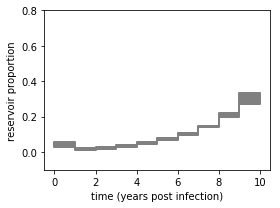

In [123]:
#example plot with estimated half life!
plt.figure(figsize=(4,3))

#without detection limits
hl=20.5
t1,Lcre1,Ltot1=get_dist(10,2,hl)

#with detection limits
hl=26.5
t2,Lcre2,Ltot2=get_dist(10,2,hl)

plt.fill_between(t1,Ltot1,Ltot2,color='gray',lw=2)

plt.ylim([-0.1,0.8])
#plt.xticks(t)
plt.xlabel('time (years post infection)')
plt.ylabel('reservoir proportion')

plt.tight_layout()
plt.savefig('figures/model_estHL.pdf',dpi=600)